In [1]:
import numpy as np
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
%matplotlib inline

# 1 Preparation

## 1.1 Device list

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17037483622762511900
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6789848269
locality {
  bus_id: 1
}
incarnation: 8061975785712869606
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]


## 1.2 Prediction algorithm description

In [3]:
classesNameNumber = {'bottle':0,'headphones':1,'human':2,'key':3,'laptop':4,'pen':5,'phone':6,'shoes':7,'sodacan':8,'wallet':9}
classesNumberName = {v:k for k, v in classesNameNumber.items()}

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.05)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.zeros(shape)
  return tf.Variable(initial)

In [5]:
graph = tf.Graph()

with graph.as_default():
    
    conv_kernel_size = 3
    conv_kernel_stride = 1
    pool_kernel_size = 2
    pool_kernel_stride = 2
    
    input_size = 224
    pool1_size = 112
    pool2_size = 56
    pool3_size = 28
    pool4_size = 14
    pool5_size = 7
    
    input_depth = 3
    block1_depth = 16
    block2_depth = 32
    block3_depth = 64
    block4_depth = 128
    block5_depth = 128
    FC1_depth = 1024
    dropout1_prob = 0.5
    FC2_depth = 1024
    dropout2_prob = 0.5
    FC_output_depth = 10
    
    conv1_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,input_depth,block1_depth])
    conv1_1_biases = bias_variable([block1_depth])
    conv1_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block1_depth])
    conv1_2_biases = bias_variable([block1_depth])
    
    conv2_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block2_depth])
    conv2_1_biases = bias_variable([block2_depth])
    conv2_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block2_depth])
    conv2_2_biases = bias_variable([block2_depth])
    
    conv3_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block3_depth])
    conv3_1_biases = bias_variable([block3_depth])
    conv3_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block3_depth])
    conv3_2_biases = bias_variable([block3_depth])
    
    conv4_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block4_depth])
    conv4_1_biases = bias_variable([block4_depth])
    conv4_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block4_depth])
    conv4_2_biases = bias_variable([block4_depth])
    
    conv5_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block5_depth])
    conv5_1_biases = bias_variable([block5_depth])
    conv5_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block5_depth,block5_depth])
    conv5_2_biases = bias_variable([block5_depth])
    
    FC1_weights = weight_variable([pool5_size,pool5_size,block5_depth,FC1_depth])
    FC1_biases = bias_variable([FC1_depth])
    FC2_weights = weight_variable([1,1,FC1_depth,FC2_depth])
    FC2_biases = bias_variable([FC2_depth])
    FC_output_weights = weight_variable([1,1,FC2_depth,FC_output_depth])
    FC_output_biases = bias_variable([FC_output_depth])
    
    saver = tf.train.Saver()
    
    def model_predict(data):
        conv1_1 = tf.nn.conv2d(data,conv1_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu1_1 = tf.nn.relu(conv1_1 + conv1_1_biases)

        conv1_2 = tf.nn.conv2d(relu1_1,conv1_2_weights,strides=[1,1,1,1],padding='SAME')
        relu1_2 = tf.nn.relu(conv1_2 + conv1_2_biases)

        pool1   = tf.nn.max_pool(relu1_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv2_1 = tf.nn.conv2d(pool1,conv2_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu2_1 = tf.nn.relu(conv2_1 + conv2_1_biases)

        conv2_2 = tf.nn.conv2d(relu2_1,conv2_2_weights,strides=[1,1,1,1], padding='SAME')
        relu2_2 = tf.nn.relu(conv2_2 + conv2_2_biases)

        pool2   = tf.nn.max_pool(relu2_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv3_1 = tf.nn.conv2d(pool2,conv3_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu3_1 = tf.nn.relu(conv3_1 + conv3_1_biases)

        conv3_2 = tf.nn.conv2d(relu3_1,conv3_2_weights,strides=[1,1,1,1],padding='SAME')
        relu3_2 = tf.nn.relu(conv3_2 + conv3_2_biases)

        pool3   = tf.nn.max_pool(relu3_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv4_1 = tf.nn.conv2d(pool3,conv4_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu4_1 = tf.nn.relu(conv4_1 + conv4_1_biases)

        conv4_2 = tf.nn.conv2d(relu4_1,conv4_2_weights,strides=[1,1,1,1],padding='SAME')
        relu4_2 = tf.nn.relu(conv4_2 + conv4_2_biases)

        pool4   = tf.nn.max_pool(relu4_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv5_1 = tf.nn.conv2d(pool4,conv5_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu5_1 = tf.nn.relu(conv5_1 + conv5_1_biases)

        conv5_2 = tf.nn.conv2d(relu5_1,conv5_2_weights,strides=[1,1,1,1],padding='SAME')
        relu5_2 = tf.nn.relu(conv5_2 + conv5_2_biases)

        pool5   = tf.nn.max_pool(relu5_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        FC1     = tf.nn.conv2d(pool5,FC1_weights,strides=[1,1,1,1],padding='VALID')
        reluFC1 = tf.nn.relu(FC1 + FC1_biases)

        FC2     = tf.nn.conv2d(reluFC1,FC2_weights,strides=[1,1,1,1],padding='VALID')
        reluFC2 = tf.nn.relu(FC2 + FC2_biases)

        FC_output = tf.nn.conv2d(reluFC2,FC_output_weights,strides=[1,1,1,1],padding='VALID') + FC_output_biases
        return tf.reshape(FC_output,[int(data.shape[0]),10])
    
    tf_one_image = tf.placeholder(tf.float32, shape=(1, input_size, input_size, input_depth))
    
    one_prediction = tf.nn.softmax(model_predict(tf_one_image))

## 1.3 Test prediction

In [6]:
training_picture_width = 256
training_picture_height = 256

In [14]:
def picture_resizing_to_first_layer(im):
    size = training_picture_width,training_picture_height
    im = im.resize(size)
    return im.crop((16,16,240,240)) #left,upper,right,bottom pixels of rectangle

In [15]:
def one_image_setup(file):
    im = Image.open(file).convert('RGB')
    im = picture_resizing_to_first_layer(im)
    pixel_depth = 255.0
    img = np.array(im).astype(np.float32)#imageio.imread(file).astype(np.float32)
    plt.imshow(np.array(im).astype(np.uint8))
    image_data = (img - pixel_depth / 2) / pixel_depth
    return np.array(image_data)

In [16]:
def one_image_prediction(img):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # not all GPU memory (1.0)
    with tf.Session(graph=graph,config=config) as session:
        saver.restore(session,'./modelTmp/modelTestSaving.ckpt')
        print('Model restored')
        pred = one_prediction.eval(feed_dict={tf_one_image:[img]})
        print()
        print('predictions:')
        for k in range(10):
            max_ind = np.argmax(pred)
            print(classesNumberName[max_ind],round(pred[0,max_ind],4))
            pred[0,max_ind] = 0.0

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
bottle 0.9242
shoes 0.0612
sodacan 0.0076
human 0.0061
pen 0.0003
key 0.0003
headphones 0.0002
wallet 0.0001
phone 0.0001
laptop 0.0


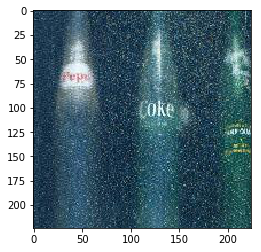

In [17]:
one_image_prediction(one_image_setup('./data/data_training/bottle/imagenetbottle0.jpg'))

# 2 Pre-prediction processing

## 2.1 Manipulator cropping

In [18]:
manipulator_height_px = 120

In [43]:
def one_image_manipulator_cropped(file):
    im = Image.open(file).convert('RGB')
    im = im.crop((0,0,im.width,im.height-manipulator_height_px)) #left,upper,right,bottom pixels of rectangle
    im = picture_resizing_to_first_layer(im)
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    img = np.array(im).astype(np.float32)
    pixel_depth = 255.0
    image_data = (img - pixel_depth / 2) / pixel_depth
    return np.array(image_data)

### 2.1.1 Test cropping

In [37]:
def one_image_manipulator_cropped_for_test(file):
    im = Image.open(file).convert('RGB')
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    im = im.crop((0,0,im.width,im.height-manipulator_height_px)) #left,upper,right,bottom pixels of rectangle
    plt.figure(figsize=(10,10))
    plt.imshow(im)

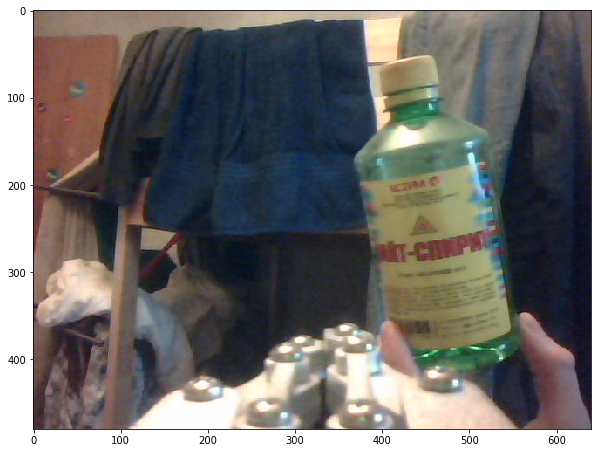

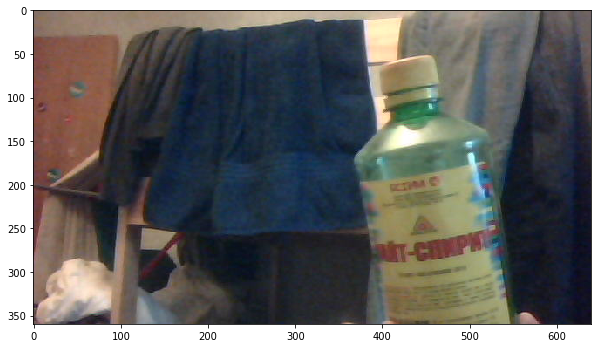

In [38]:
img_data = one_image_manipulator_cropped_for_test('./ir_nikita/ir_nikita/3.jpg')

### 2.1.2 Predictions

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
shoes 0.3733
headphones 0.367
human 0.1896
pen 0.0224
phone 0.017
key 0.0164
bottle 0.0066
sodacan 0.0062
laptop 0.0007
wallet 0.0007


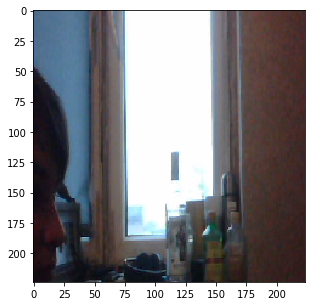

In [45]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/1.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
shoes 0.6591
human 0.1238
headphones 0.0998
phone 0.0686
pen 0.0303
laptop 0.0077
key 0.005
bottle 0.0039
wallet 0.0017
sodacan 0.0001


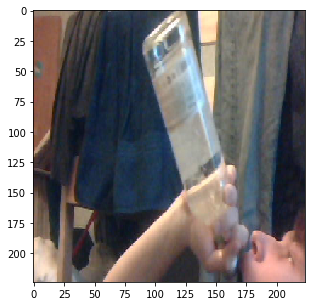

In [46]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/2.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
phone 0.2569
shoes 0.2298
human 0.203
pen 0.1061
key 0.0747
sodacan 0.0561
bottle 0.0316
headphones 0.0271
wallet 0.0112
laptop 0.0036


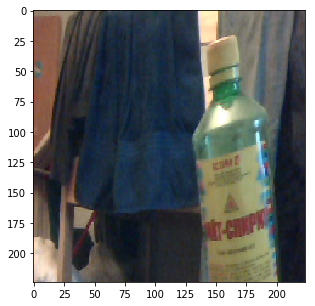

In [47]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/3.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.7619
laptop 0.0826
headphones 0.0794
shoes 0.0722
phone 0.0018
bottle 0.001
pen 0.0009
key 0.0001
wallet 0.0
sodacan 0.0


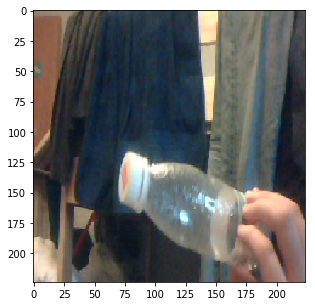

In [48]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/4.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.8966
headphones 0.0841
shoes 0.0179
key 0.0007
phone 0.0004
bottle 0.0002
sodacan 0.0001
pen 0.0001
laptop 0.0001
wallet 0.0


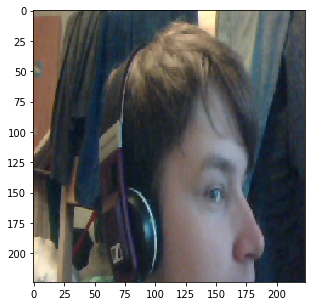

In [49]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/5.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.7968
shoes 0.1365
bottle 0.0272
pen 0.0153
headphones 0.0088
key 0.0067
phone 0.004
sodacan 0.0035
laptop 0.0011
wallet 0.0001


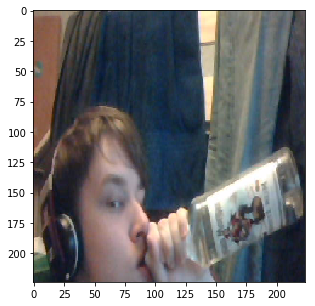

In [50]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/6.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.9477
headphones 0.0249
shoes 0.0143
laptop 0.0101
bottle 0.0019
phone 0.0005
pen 0.0002
wallet 0.0001
sodacan 0.0001
key 0.0


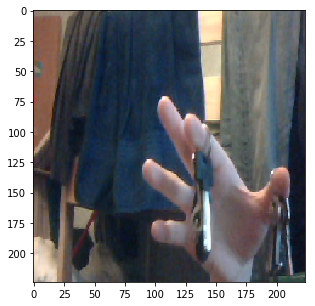

In [51]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/7.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.9962
shoes 0.0017
bottle 0.0017
headphones 0.0002
sodacan 0.0002
pen 0.0
key 0.0
laptop 0.0
wallet 0.0
phone 0.0


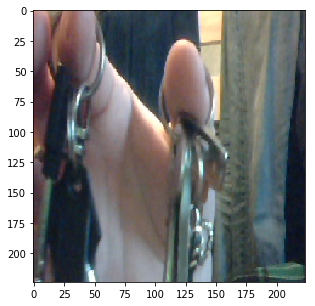

In [52]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/8.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
shoes 0.6941
headphones 0.172
pen 0.0587
human 0.0284
bottle 0.0202
key 0.0117
laptop 0.0082
phone 0.0059
wallet 0.0005
sodacan 0.0003


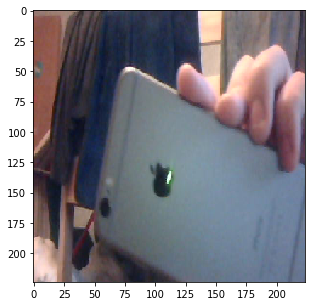

In [53]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/9.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.4608
shoes 0.3732
key 0.0697
bottle 0.0494
headphones 0.0164
sodacan 0.0118
pen 0.0106
phone 0.0067
laptop 0.0014
wallet 0.0001


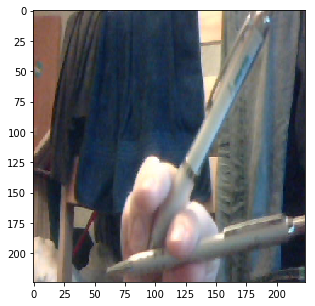

In [54]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/10.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.3167
shoes 0.2841
headphones 0.2474
phone 0.0702
laptop 0.0364
key 0.0333
wallet 0.0087
pen 0.0024
bottle 0.0006
sodacan 0.0002


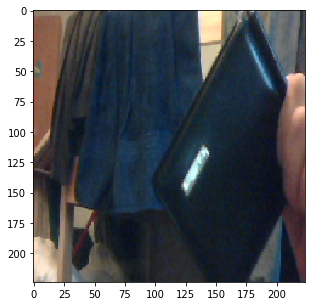

In [55]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/11.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
shoes 0.5771
human 0.1827
laptop 0.0801
bottle 0.0402
key 0.0387
pen 0.0343
phone 0.0231
headphones 0.0161
wallet 0.0054
sodacan 0.0023


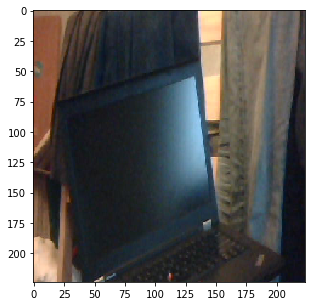

In [57]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/12.jpg'))

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
human 0.8369
headphones 0.0628
shoes 0.0626
phone 0.0196
laptop 0.0164
bottle 0.0012
sodacan 0.0003
key 0.0002
wallet 0.0
pen 0.0


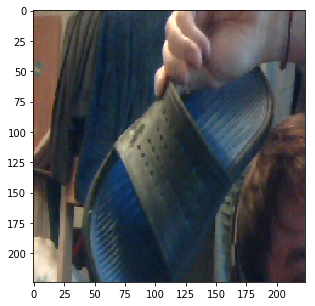

In [58]:
one_image_prediction(one_image_manipulator_cropped('./ir_nikita/ir_nikita/13.jpg'))

In [1]:
5456./3632.

1.502202643171806

In [2]:
640./480.

1.3333333333333333

In [ ]:
1.3333 = x/3632.

In [3]:
1.3333*3632.

4842.5455999999995

In [1]:
5456-4842

614